# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [142]:
import pandas as pd
from pymystem3 import Mystem 
from collections import Counter
data = pd.read_csv("/datasets/data.csv")
data.info() 
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [143]:
for row in data:
    print(data[row].unique()) 
    #print(data[row].value_counts()) 

[ 1  0  3  2 -1  4 20  5]
[-8437.67302776 -4024.80375385 -5623.42261023 ... -2113.3468877
 -3112.4817052  -1984.50758853]
[42 36 33 32 53 27 43 50 35 41 40 65 54 56 26 48 24 21 57 67 28 63 62 47
 34 68 25 31 30 20 49 37 45 61 64 44 52 46 23 38 39 51  0 59 29 60 55 58
 71 22 73 66 69 19 72 70 74 75]
['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']
[0 1 2 3 4]
['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем']
[0 1 2 3 4]
['F' 'M' 'XNA']
['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете']
[0 1]
[253875.6394526  112080.01410244 145885.95229686 ...  89672.56115303
 244093.05050043  82047.41889948]
['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на провед

In [144]:
data.isna().mean()

children            0.000000
days_employed       0.100999
dob_years           0.000000
education           0.000000
education_id        0.000000
family_status       0.000000
family_status_id    0.000000
gender              0.000000
income_type         0.000000
debt                0.000000
total_income        0.100999
purpose             0.000000
dtype: float64

In [145]:
data.describe() 

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


**Вывод**

Название столбцов выполнено корректно. В датасете 21525 строк, в двух столбцах есть пропуски.

Посмотрим на каждый столбец, и прокомментируем проблемные моменты:

children - количество детей - есть отрицательные значение -1 (встречается 47 раз) и значение 20 (76 раз, поиск в интернете выдает, что в России такая семья всего одна).

days_employed - общий трудовой стаж в днях - есть отрицательные значения (возможно, при вводе было поставлено тире перед числом) тип данных float64, необхожимо поменять на int т.к. речь идет о днях стажа, и это число должно быть целым. Также здесь есть пропуски - 10% от всей выборки.
Нужно заменить отрицательные значения (в рамках данной работы, заменим их на положительные), поменять тип данных и обратить внимание на артефакты (сейчас уже видим, например, 340266 дней стажа, это более 931 года), от них нужно будет избавиться.

dob_years - возраст клиента в годах - есть нулевые значения (их 101). 

gender - есть значение XNA (одно).

education - здесь встречаются дубликаты - необходимо все сделать с маленькой буквы.

total_income - содержит пропуски, как и в случае с трудовым стажем, их 10%. Посмотрим связь этих пропусков в обоих столбцах.
тип данных float64 необхожимо поменять на int.


## Шаг 2. Предобработка данных

### Обработка пропусков

In [146]:
data.loc[data['children'] == -1, 'children'] = 1 # заменим количество детей -1 на 1
data.loc[data['children'] == 20, 'children'] = 2 # заменим количество детей 20 на 2
data.loc[data['gender'] == 'XNA', 'gender'] = '' # заменим пол XNA на пустое значение
data.loc[data['dob_years'] == 0, 'dob_years'] = data['dob_years'].mean() # заменим нулевой возраст на средний

data['days_employed_corrected'] = data['days_employed'].abs() 
## обновление - создадим новый столбец с данными о стаже и заменим отрицательные значения возраста на положительные

def delete_unreal(days): # создадим функцию, которая артефактам присваивает 'NaN'
    if days > (60*365):
        return 'NaN'
    else:
        return days   
    
data['days_employed_corrected'] = data['days_employed_corrected'].apply(delete_unreal)
# применим созданную функцию к сохданному столбцу с данными о стаже
data['days_employed_corrected'] = pd.to_numeric(data['days_employed_corrected'], errors='coerce')
# превратим значения нового столбца в числовой тип float64, чтобы посчитать среднее
data['days_employed_corrected'] = data['days_employed_corrected'].fillna(data['days_employed_corrected'].mean())
# заменим пропущенные значения дней стажа в новом столбце на средние по выборке
  
data['total_income_corrected'] = data['total_income'] #создадим новый столбец с данными о доходе для манипуляций 
data['total_income_corrected'] = data['total_income_corrected'].fillna(data.groupby('income_type')['total_income_corrected'].transform('median'))
## обновление - замена пропусков в доходе на медиану в зависимости от трудовой категории

data.info() # проверка
data[data['total_income'].isnull()].head(5) # проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 14 columns):
children                   21525 non-null int64
days_employed              19351 non-null float64
dob_years                  21525 non-null float64
education                  21525 non-null object
education_id               21525 non-null int64
family_status              21525 non-null object
family_status_id           21525 non-null int64
gender                     21525 non-null object
income_type                21525 non-null object
debt                       21525 non-null int64
total_income               19351 non-null float64
purpose                    21525 non-null object
days_employed_corrected    21525 non-null float64
total_income_corrected     21525 non-null float64
dtypes: float64(5), int64(4), object(5)
memory usage: 2.3+ MB


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_corrected,total_income_corrected
12,0,NaN,65.0,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу,2353.015932,118514.486412
26,0,NaN,41.0,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование,2353.015932,150447.935283
29,0,NaN,63.0,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости,2353.015932,118514.486412
41,0,NaN,50.0,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем,2353.015932,150447.935283
55,0,NaN,54.0,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу,2353.015932,118514.486412


В данной части мы заменили пропуски, а также значения, которые были были введены неверно (отрицательное количество детей или дней стажаб, нулевой возраст). Замены пропусков на среднее или медиану были выполнены в новых столбцах, чтобы сохранить оригинальные данные.

children - В рамках данного проекта мы предполагаем, что при вводе были допущены ошибки, и заменим количество детей "-1" на "1", и "20" на "2". Также заменим в gender пол 'XNA' на пустое значение.

dob_years - возраст - количественная переменная, пропуски в таких переменных заполняют характерными значениями. Заменим значение возраста ноль на среднее арифметическое по выборке. 

Пропуски в данных: days_employed и total_income содержат 19351 non-null, там есть NaN. Отсутствуют данные о днях и доходе одновременно для одних и тех же строк. 
Причины появления пропусков в данных - возможно, человек намеренно не указал данные о отработанных днях и доходе. Т.к. корректные данные по стажу полностью отсутствуют у категории пенсионеров и безработных, возможно, их стаж вводился в другом формате (например, в часах).

days_employed - в новом столбце days_employed_corrected мы превратили отрицательные значения в положительные, а артефакты (стаж больше 60 лет) - в NaN. После коррекции, мы заметили, что отсутствуют данные по стажу по пенсионерам и безработным. Группа безработных довольно мала - их всего двое. Заменить все пропущенные значения на среднее или медиану по выборке, не самое точное решение.  Тем не менее, для упражнения мы их заменили средним (медиана более низкое значение, чем среднее, а т.к. пенсионеры - это группа, где стаж должен быть наиболее высоким, выбираем среднее).

total_income - доход - создадим новый столбец total_income_corrected и там заменим пропущенные данные медианой по доходу в зависимости от категории занятости. Мы выбрали медиану, т.к. для дохода она подходит лучше, нежели среднее арифметическое, если есть в группе люди с доходом, который сильно отличается от остальных.

### Замена типа данных

In [147]:
data['days_employed_corrected'] = data['days_employed_corrected'].astype('int')
data['total_income_corrected'] = data['total_income_corrected'].astype('int')
data['dob_years'] = data['dob_years'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 14 columns):
children                   21525 non-null int64
days_employed              19351 non-null float64
dob_years                  21525 non-null int64
education                  21525 non-null object
education_id               21525 non-null int64
family_status              21525 non-null object
family_status_id           21525 non-null int64
gender                     21525 non-null object
income_type                21525 non-null object
debt                       21525 non-null int64
total_income               19351 non-null float64
purpose                    21525 non-null object
days_employed_corrected    21525 non-null int64
total_income_corrected     21525 non-null int64
dtypes: float64(2), int64(7), object(5)
memory usage: 2.3+ MB


**Вывод**

В таблице столбец с возрастом и новые столбцы с открорректированными данными по стажу и доходу, обозначены как вещественные (тип float64). Они заменены на на целочисленные тк возраст - в полных годах, откорректированное количество стажа - в полных  днях и откорректированный доход - в годовом доходе в рублях.

***
*Также у нас есть другие целочисленные переменные (для сокращения занимаемой памяти, им можно было бы поменять тип):
children - количество детей
dob_years - полный возраст
education_idб - идентификаторт обучения (категориальная переменная)
family_status_id - идентификатор семейного положения (категориальная переменная)
debt - int, возврат крудита (должен быть логической переменной. Если событие истинно - т.е. долг был взят, то переменная принимает значение 1, соответствующее True, а если ложно — 0).

### Обработка дубликатов

In [149]:
data['education'] = data['education'].str.lower()
#data.groupby('education')['education'].agg(['count']).apply(lambda x: x.sort_values(ascending=False)) #заменим на value_counts
data['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

In [150]:
data.duplicated().sum()

71

In [151]:
data = data.drop_duplicates()
data.duplicated().sum()

0

**Вывод**

Мы заменили разные написания типов образования на написание с маленькой буквы, создав функцию и применив ее в столбцу с образованием. Теперь, дубликаты отсутствуют. Подавляющее число заемщиков имеют среднее образование

### Лемматизация

In [156]:
m = Mystem() 
list_purposes = data['purpose'].unique()
lemmas_list=[]

for i in range(len(list_purposes)):
    text = list_purposes[i]
    lemmas = m.lemmatize(text)
    lemmas_list +=lemmas
print(Counter(lemmas_list)) 

def check_purpose(text):
    lemmas = m.lemmatize(text)
    #return lemmas
    frequent_purposes = ['ремонт','недвижимость', 'автомобиль', 'образование', 'жилье', 'свадьба',]
    for word in frequent_purposes:
        if word in lemmas:
            return word

data['purposes_corrected'] = data['purpose'].apply(check_purpose)
#print(data['purposes_corrected'])

#data.groupby('purposes_corrected')['purposes_corrected'].agg(['count']).apply(lambda x: x.sort_values(ascending=False))
#заменим на value_counts
data['purposes_corrected'].value_counts()

Counter({' ': 59, '\n': 38, 'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'операция': 4, 'на': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'заниматься': 2, 'сделка': 2, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'подержать': 1, 'со': 1, 'подержанный': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1})


недвижимость    6351
автомобиль      4306
образование     4013
жилье           3853
свадьба         2324
ремонт           607
Name: purposes_corrected, dtype: int64

**Вывод**

Для списка уникальных значений по цели кредита мы получили леммы, и проанализировали их частоту появления. Таким образом мы можем составить список основных целей кредита:  
- недвижимость 
- жильё
- автомобиль
- образование
- свадьба
- ремонт (*встречается в словосочетании ремонт жилью, а потому должен быть отличен от покупки жилья и подобного - для этого он первый в списке на проверку функцией)

Далее мы обработали весь датасет, и в новом столбце присвоили каждой цели одну из шести основных целей.
Самая популярная цель кредита - на операции, связанные с недвижимостью и покупку автомобиля. Далее следуют образование и покупка жилья. Мы не стали объединять недвижимость и жилье, чтобы сохранить разницу между жильем как недвижимостью для проживания самого человека, а не для сдачи или иных целей. Последние места занимают свадьба и ремонт, но, возможно, кредит для таких целей меньше, и его, возможно, чаще возвращают в срок (гипотеза).

### Категоризация данных

In [172]:
education_dict = data [['education', 'education_id']].drop_duplicates().reset_index(drop=True)
education_dict

,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


In [173]:
family_status = data [['family_status', 'family_status_id']].drop_duplicates().reset_index(drop=True)
family_status

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


In [160]:
data_log = data[['children','days_employed_corrected', 'dob_years', 'education_id', 'family_status_id','gender', 'income_type', 'total_income_corrected', 'debt', 'purposes_corrected' ]]
data_log.head(5)


,children,days_employed_corrected,dob_years,education_id,family_status_id,gender,income_type,total_income_corrected,debt,purposes_corrected
0,1,8437,42,0,0,F,сотрудник,253875,0,жилье
1,1,4024,36,1,0,F,сотрудник,112080,0,автомобиль
2,0,5623,33,1,0,M,сотрудник,145885,0,жилье
3,3,4124,32,1,0,M,сотрудник,267628,0,образование
4,0,2353,53,1,1,F,пенсионер,158616,0,свадьба


**Вывод**

Мы выделили семейный статус и обучение в два отдельных "словаря", а основной датасет стал "легче" для манипуляций, так как там мы оставили только идентификаторы и откорректированные ранее столбцы.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [161]:
data_log.groupby('children')['debt'].agg(['count','sum','mean'])

,count,sum,mean
children,,,
0,14091,1063,0.075438
1,4855,445,0.091658
2,2128,202,0.094925
3,330,27,0.081818
4,41,4,0.097561
5,9,0,0.000000


In [162]:
def children_dummy(child_number): # функция проверяет есть ли дети, 1 - есть, 0 - нет
    if child_number > 0:
        return 1
    return 0

data_log['children_group'] = data_log['children'].apply(children_dummy) # работаем с data_log, датасетом поссле категоризации
data_log.groupby('children_group')['debt'].agg(['count','sum','mean'])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,count,sum,mean
children_group,,,
0,14091,1063,0.075438
1,7363,678,0.092082


**Вывод**

Люди с детьми чаще задерживают выплату кредита - в 9,2% случаев, в то время как те, кто детей не имеет, - в 7,5%. 
Таким образом, наличие детей может негативно влиять на возврат кредита в срок. Возможно, это связано с тем, что у заемщиков с детьми чаще возникают непредвиденные расходы и им сложнее планировать свой бюджет.

*Chi-Squared Test https://www.evanmiller.org/ab-testing/chi-squared.html#!1063/14149;678/7376@95

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [163]:
data_log.groupby('family_status_id')['debt'].agg(['count','sum','mean'])

,count,sum,mean
family_status_id,,,
0,12339,931,0.075452
1,4151,388,0.093471
2,959,63,0.065693
3,1195,85,0.071130
4,2810,274,0.097509


In [164]:
data_log.groupby('gender')['debt'].agg(['count','sum','mean'])

,count,sum,mean
gender,,,
,1,0,0.000000
F,14174,994,0.070128
M,7279,747,0.102624


In [165]:
data_log.pivot_table(index=['family_status_id', 'gender'], values='debt', aggfunc=('count', 'sum','mean'))

count      mean    sum
family_status_id gender                         
0                F       7760.0  0.068299  530.0
                 M       4579.0  0.087574  401.0
1                           1.0  0.000000    0.0
                 F       2845.0  0.081898  233.0
                 M       1305.0  0.118774  155.0
2                F        904.0  0.057522   52.0
                 M         55.0  0.200000   11.0
3                F        936.0  0.065171   61.0
                 M        259.0  0.092664   24.0
4                F       1729.0  0.068248  118.0
                 M       1081.0  0.144311  156.0

**Вывод**

Чаще всех задерживают выплату кредита не женатые/не замужние - 9.7%, и те, кто состоят в гражданском браке - 9.3%. Реже всего задержки с кредитами у вдовцов/вдов - 6.6%, далее разведенные и состоящие в официальном браке. 
Таким образом, официально закрепленный семейный статус положительно влияет на возврат кредита в срок. Возможно, что люди состоящие или бывшие в браке чаще готовы брать на себя обязательства и выполнять их.

Заметим, что пол вляет на возврат кредита в срок - женщины отдают кредит вовремя чаще - на 3.3%. И если мы посмотрим на категорию вдоцов и вдов, разделенных по полу, то заметим, что, во-первых, женщин среди них в 16 раз больше (из-за различия в средней продолжительности жизни) и что у заемщиц - вдов задержки по выплатам 5.8%, а у заемщиков - вдовцов - 20%. Также довольна существенна разница между не женатыми и не замужними - первые задерживают выплаты на 7.6% чаще вторых. Такие факторы должны быть учтены при построении скоринга.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [166]:
data_log.groupby('total_income_corrected')['debt'].agg(['count','sum','mean'])
#data['total_income_corrected_cut'] = pd.cut(data['total_income_corrected'],5)
data['total_income_corrected_cut2'] = pd.cut(data['total_income_corrected'],[0,50000, 75000,100000,125000,150000,175000,200000,250000,500000,2265604])
#data.groupby('total_income_corrected_cut')['debt'].agg(['count','sum','mean'])
data.groupby('total_income_corrected_cut2')['debt'].agg(['count','sum','mean'])

,count,sum,mean
total_income_corrected_cut2,,,
"(0, 50000]",372,23,0.061828
"(50000, 75000]",1493,113,0.075687
"(75000, 100000]",2598,218,0.083911
"(100000, 125000]",3292,289,0.087789
"(125000, 150000]",3868,335,0.086608
"(150000, 175000]",3053,255,0.083524
"(175000, 200000]",1711,150,0.087668
"(200000, 250000]",2254,164,0.072760
"(250000, 500000]",2591,180,0.069471


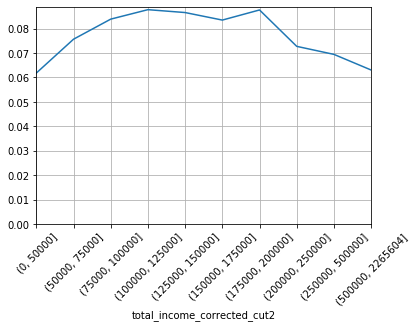

In [167]:
data.groupby('total_income_corrected_cut2')['debt'].mean().plot(ylim=0,rot=45,grid=True)

**Вывод**


Зависимость между уровнем дохода и выплатой кредита в срок - нелинейная. Люди с самыми низкими доходами - ниже 50000 и с самыми высокими - выше 500000 практически одинаково низко задерживают выплаты кредита, 6.2% и 6.3%. Повышение дохода далеко не сразу сопровождается понижением задержек по выплатам кредитов. Самый выской процент задержек по кредитам (8.4 -8.8%) находится у тех, у кого доходы от 75000 до 200000. Чтобы лучше развобраться в этом феномене, нам необходимо подключать информацию о размере кредита. 

Возможно, люди с самым низким доходом берут совсем небольшой кредит, и поэтому выплачивают его вовремя с большей частотой, чем люди с более выским доходом. Начиная с дохода 200 000 процент задержек начинает линейно снижаться, то есть этот размер дохода может быть условным экватором после которого выплаты в кредита в срок повышается более чем на полтора процента.

- Как разные цели кредита влияют на его возврат в срок?

In [168]:
#data_log.groupby('purposes_corrected')['debt'].agg(['count','sum','mean']) - теперь сделано через pivot_table

In [169]:
data_log.pivot_table(index=['purposes_corrected'], values='debt', aggfunc=('count', 'sum','mean'))

,count,mean,sum
purposes_corrected,,,
автомобиль,4306.0,0.093590,403.0
жилье,3853.0,0.070854,273.0
недвижимость,6351.0,0.074634,474.0
образование,4013.0,0.092200,370.0
ремонт,607.0,0.057661,35.0
свадьба,2324.0,0.080034,186.0


In [170]:
data_log.pivot_table(index=['income_type'], values='debt', aggfunc=('count', 'sum','mean'))

,count,mean,sum
income_type,,,
безработный,2.0,0.500000,1.0
в декрете,1.0,1.000000,1.0
госслужащий,1457.0,0.059025,86.0
компаньон,5078.0,0.074045,376.0
пенсионер,3829.0,0.056412,216.0
предприниматель,2.0,0.000000,0.0
сотрудник,11084.0,0.095724,1061.0
студент,1.0,0.000000,0.0


**Вывод**

Самый выской процент задержки по кредитам на автомобиль - 9.34% и образование - 9.2%. Меньше всего задережек, если кредит взят на ремонт (но и кредитов такх сравнительно немного) - 5.7%, далее следует жилье - 7.1% и недвижимость - 7.5%.

Кредиты на автомобиль и образования меньше по сумме, нежели на жилье и недвижимость, и задолженность по ним, воможно, также воспринимается людьми как менее "серьезная". Кредит на жилье - это, как правило ипотека, где за невыплату штрафы могут иметь более серьезные последствия (вплоть до того, что могут отобрать жилье). Покупка автомобиля - может быть связана с демонстративным или показным потерблением, когда люди хотят купить более дорогую машину для повышения своего статуса, но выплатить кредит за нее им сложнее из-за ограниченного дохода.

Более высокой процент по задолженностям из-за образования может быть связан с тем, что заемщики чаще задерживают выплату из-за неверно оценненного ожидания повышения доходов как следствия полученного образования. Заметим, что студент в выборке всего один.

Ремонт предпологает более низкую сумму кредита, возможно, это объясняет что такие кредиты чаще отдаются в срок.


## Шаг 4. Общий вывод

Возврат кредита в срок осуществляется чаще людьми, у которых нет детей, и есть официальный брачный статус. Цель кредита влияет на его выплату в срок -  чаще других задеживают кредиты, взятые на автомобили и образование. Зависимость дохода и возврата кредита в срок - нелинейна, и должна быть изучена дополнительно: пока что мы можем заметить, что люди с самыми низкими, или, наоборот, с самыми выскоми доходами отдают кредит в срок чаще, чем те, что со средними доходами.